# Assignment 2: Convolutional Neural Networks and AutoML
---

### Import Required Libraries
Import the necessary libraries, including PyTorch and the chosen hyperparameter optimization library. Also import local modules and set global variables.

In [1]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from support import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import optuna
from model import SimpleCNN
from train_test_optimize import train_model, test_model, objective_with_cv
from functools import partial
import numpy as np

In [2]:
# Define global parameters
EPOCHS = 25
N_TRIALS = 2
MODEL = SimpleCNN
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")

Device: cuda


### Load and Preprocess the Wefabricate Dataset
Load the Wefabricate dataset and preprocess it for use with a CNN. Preprocessing is handles by the `load_dataset` function from `support.py`.

In [3]:
train_data, test_data = load_dataset()

print(f"Train data: {len(train_data)}")
print(f"Test data: {len(test_data)}")

Train data: 136
Test data: 34


### Visualize data with their labels
Check a few samples from the train loader to see wheter the labels match the images.

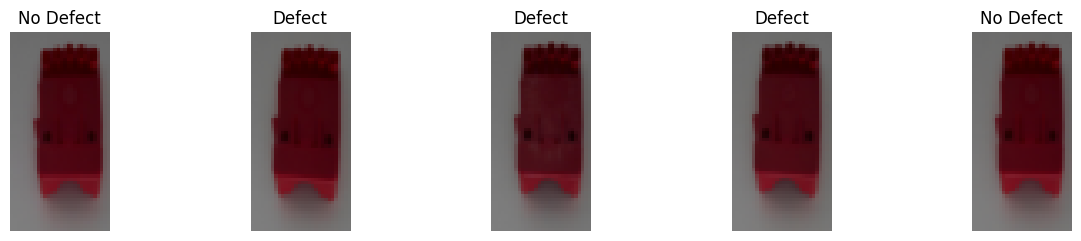

In [4]:
# Define the class labels 
class_labels = ["Defect", "No Defect"]

# Get a batch of training data
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
images, labels = next(iter(train_loader))

# Create a grid of the images and print the labels
plt.figure(figsize=(15, 15))
for i in range(5):
    plt.subplot(5, 5, i + 1)
    plt.imshow(np.transpose(images[i], (1, 2, 0)))
    plt.axis('off')
    plt.title(class_labels[labels[i]])
    
plt.show()

### Define the CNN Model
Define a CNN to classify product images in the Wefabricate dataset. The `SimpleCNN` model class is defined in `model.py`.

In [5]:
# Instantiate the network
model = SimpleCNN(dropout_rate=0.25)

### Train the CNN Model
Train the CNN model on the training set. First define the loss and optimizer functions and ensure model is on DEVICE (GPU, if available). The `train_model` function is defined in `train_test_optimize`, which saves models with the `model_name` prefix to the `models/` folder.

In [6]:
# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

# Move the model to the device
model.to(DEVICE)

# Train the model
train_losses, val_losses = train_model(model, train_data, criterion, optimizer, DEVICE, n_epochs=EPOCHS, model_name="initial_model", val_split=0.2)

Training Epoch 1/25: 100%|██████████| 2/2 [00:06<00:00,  3.09s/it]


Epoch 1, Train Loss: 0.7165, Val Loss: 0.7379, Train Acc: 53.70%, Val Acc: 42.86%


Training Epoch 2/25: 100%|██████████| 2/2 [00:05<00:00,  2.95s/it]


Epoch 2, Train Loss: 0.6962, Val Loss: 0.7485, Train Acc: 52.78%, Val Acc: 42.86%


Training Epoch 3/25: 100%|██████████| 2/2 [00:05<00:00,  2.95s/it]


Epoch 3, Train Loss: 0.7276, Val Loss: 0.7218, Train Acc: 50.00%, Val Acc: 42.86%


Training Epoch 4/25: 100%|██████████| 2/2 [00:05<00:00,  2.91s/it]


Epoch 4, Train Loss: 0.7010, Val Loss: 0.6909, Train Acc: 50.93%, Val Acc: 42.86%


Training Epoch 5/25: 100%|██████████| 2/2 [00:05<00:00,  2.95s/it]


Epoch 5, Train Loss: 0.6819, Val Loss: 0.6778, Train Acc: 57.41%, Val Acc: 60.71%


Training Epoch 6/25: 100%|██████████| 2/2 [00:05<00:00,  2.94s/it]


Epoch 6, Train Loss: 0.6744, Val Loss: 0.6739, Train Acc: 51.85%, Val Acc: 71.43%


Training Epoch 7/25: 100%|██████████| 2/2 [00:05<00:00,  2.94s/it]


Epoch 7, Train Loss: 0.6615, Val Loss: 0.6695, Train Acc: 66.67%, Val Acc: 64.29%


Training Epoch 8/25: 100%|██████████| 2/2 [00:05<00:00,  2.96s/it]


Epoch 8, Train Loss: 0.6658, Val Loss: 0.6704, Train Acc: 59.26%, Val Acc: 71.43%


Training Epoch 9/25: 100%|██████████| 2/2 [00:05<00:00,  2.95s/it]


Epoch 9, Train Loss: 0.6632, Val Loss: 0.6711, Train Acc: 69.44%, Val Acc: 60.71%


Training Epoch 10/25: 100%|██████████| 2/2 [00:05<00:00,  2.95s/it]


Epoch 10, Train Loss: 0.6526, Val Loss: 0.6743, Train Acc: 68.52%, Val Acc: 60.71%


Training Epoch 11/25: 100%|██████████| 2/2 [00:05<00:00,  2.92s/it]


Epoch 11, Train Loss: 0.6384, Val Loss: 0.6699, Train Acc: 70.37%, Val Acc: 60.71%


Training Epoch 12/25: 100%|██████████| 2/2 [00:05<00:00,  2.95s/it]


Epoch 12, Train Loss: 0.6404, Val Loss: 0.6638, Train Acc: 67.59%, Val Acc: 64.29%


Training Epoch 13/25: 100%|██████████| 2/2 [00:05<00:00,  2.94s/it]


Epoch 13, Train Loss: 0.6153, Val Loss: 0.6547, Train Acc: 72.22%, Val Acc: 71.43%


Training Epoch 14/25: 100%|██████████| 2/2 [00:05<00:00,  2.92s/it]


Epoch 14, Train Loss: 0.6466, Val Loss: 0.6479, Train Acc: 65.74%, Val Acc: 71.43%


Training Epoch 15/25: 100%|██████████| 2/2 [00:05<00:00,  2.94s/it]


Epoch 15, Train Loss: 0.6173, Val Loss: 0.6434, Train Acc: 70.37%, Val Acc: 71.43%


Training Epoch 16/25: 100%|██████████| 2/2 [00:05<00:00,  2.94s/it]


Epoch 16, Train Loss: 0.5994, Val Loss: 0.6425, Train Acc: 75.00%, Val Acc: 71.43%


Training Epoch 17/25: 100%|██████████| 2/2 [00:05<00:00,  2.95s/it]


Epoch 17, Train Loss: 0.5906, Val Loss: 0.6384, Train Acc: 78.70%, Val Acc: 71.43%


Training Epoch 18/25: 100%|██████████| 2/2 [00:05<00:00,  2.99s/it]


Epoch 18, Train Loss: 0.6016, Val Loss: 0.6330, Train Acc: 73.15%, Val Acc: 71.43%


Training Epoch 19/25: 100%|██████████| 2/2 [00:06<00:00,  3.00s/it]


Epoch 19, Train Loss: 0.5906, Val Loss: 0.6250, Train Acc: 76.85%, Val Acc: 75.00%


Training Epoch 20/25: 100%|██████████| 2/2 [00:05<00:00,  2.97s/it]


Epoch 20, Train Loss: 0.5854, Val Loss: 0.6209, Train Acc: 75.00%, Val Acc: 75.00%


Training Epoch 21/25: 100%|██████████| 2/2 [00:05<00:00,  2.97s/it]


Epoch 21, Train Loss: 0.5544, Val Loss: 0.6193, Train Acc: 80.56%, Val Acc: 75.00%


Training Epoch 22/25: 100%|██████████| 2/2 [00:06<00:00,  3.01s/it]


Epoch 22, Train Loss: 0.5761, Val Loss: 0.6167, Train Acc: 71.30%, Val Acc: 75.00%


Training Epoch 23/25: 100%|██████████| 2/2 [00:05<00:00,  2.95s/it]


Epoch 23, Train Loss: 0.5668, Val Loss: 0.6096, Train Acc: 75.93%, Val Acc: 75.00%


Training Epoch 24/25: 100%|██████████| 2/2 [00:05<00:00,  2.96s/it]


Epoch 24, Train Loss: 0.5548, Val Loss: 0.6016, Train Acc: 75.00%, Val Acc: 64.29%


Training Epoch 25/25: 100%|██████████| 2/2 [00:05<00:00,  2.96s/it]


Epoch 25, Train Loss: 0.5359, Val Loss: 0.5951, Train Acc: 81.48%, Val Acc: 64.29%
Finished Training


### Visualize the training and validation loss over epochs
Visualizing the train and validation loss allows for identifying potential problems the learning rate or model complexity. Additionally, overfitting can be identified when the validation loss divergences from the training loss after certain epochs.

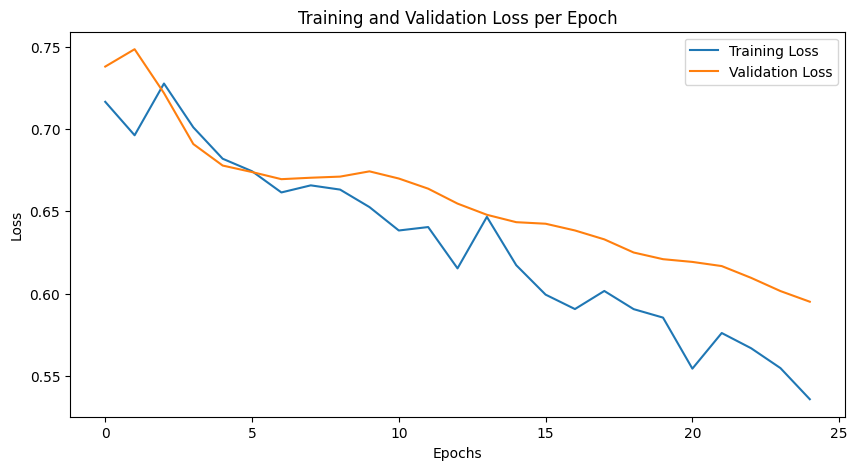

In [7]:
# Visualize the training loss over epochs
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss per Epoch")
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Test the CNN Model
Test the trained CNN model on the test set and calculate performace metrics. The `test_model` function is defined in the `train_test_optimize.py` module.

In [8]:
# Test model on the test data and get metrics
accuracy, precision, recall, f1 = test_model(model, test_data, DEVICE)

# Visualize the metrics in a table
metrics = pd.DataFrame({
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1': [f1]
})

print(metrics)

Testing: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]

   Accuracy  Precision    Recall        F1
0  0.617647   0.611111  0.647059  0.628571


### Hyperparameter Selection
First hyperparameters of interest are described after which both random search and Tree-structured Parzen Estimator (TPE) search HPO is performed with a 5-fold cross-validation scheme.

#### 1) Learning Rate

**Importance:**  
The learning rate is fundamental as it determines how much to update the model's weights based on the error each time the model weights are updated. If set too high, the model might overshoot the minimum, leading to erratic behaviors. If too low, the model could take too long to converge or might get stuck in a local minimum.

**Relevance to Wefabricate:**  
Given that we are dealing with a small dataset (136 training images), an optimal learning rate is crucial to ensure efficient convergence without overshooting, as CNNs are sensitive to this parameter in such scenarios.

#### 2) Batch Size

**Importance:**  
The batch size affects the stability of the training process. Larger batch sizes result in smoother (less noisy) gradient estimates, but are computationally more demanding and can lead to poorer generalization. Smaller batches can offer a regularizing effect and lower generalization error.

**Relevance to Wefabricate:**  
Adjusting the batch size can help balance between computation efficiency and model performance, especially when resources are limited or when the dataset is small, as is the case in the Wefabricate dataset.

#### 3) Dropout rate

**Importance:**
This parameter controls the fraction of neurons that are randomly dropped out during training to prevent overfitting. A higher dropout rate means more neurons are ignored during each forward and backward pass, which helps in regularizing the model and improving its generalization capabilities. However, if the dropout rate is too high, the model might underfit, failing to learn important patterns in the data.

**Relevance to Wefabricate:**
Optimal dropout rate setting ensures that the model remains robust and generalizes well to new, unseen images by preventing it from memorizing the noise in the training data. This is particularly important given the limited data available, as it helps the model learn meaningful patterns without overfitting.

#### 4) Weight Decay

**Importance:**  
Weight decay (L2 regularization) helps prevent overfitting by penalizing large weights. This regularization method encourages simpler models that may generalize better on unseen data.

**Relevance to Wefabricate:**  
With a relatively small dataset and a potentially complex model, weight decay can help maintain the balance between bias and variance, thus improving the model's general performance on new, unseen images.

#### 5) Optimizer

**Importance:**  
The choice of optimizer can significantly affect the training speed and quality of the final model. Different optimizers can manage different types of data and architectures more effectively, with some being better at handling noisy gradients or avoiding local minima.

**Relevance to Wefabricate:**  
Given the task's sensitivity to hyperparameter settings due to the small data size, choosing the right optimizer (like Adam, which is generally robust, or SGD, which might benefit from fine-grained control over learning momentum) can lead to better or faster convergence in training the CNN.


### 5-Fold Cross-Validation Hyperparameter Optimization with Optuna
Perform 5-fold cross-validation on the training set to calculate the validation accuracy for the hyperparameters. The optimal hyperparameters are selected.

In [9]:
# Create the objective function with partial
objective = partial(objective_with_cv, n_epochs=EPOCHS, model_class=MODEL, train_data=train_data, device=DEVICE)

In [10]:
# Random search with Optuna
study_random = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler())
study_random.optimize(objective, n_trials=N_TRIALS)
best_params_random = study_random.best_trial.params

[I 2024-06-01 11:44:11,580] A new study created in memory with name: no-name-a80339b9-b803-4ff0-9115-70a72d89ae0e
[I 2024-06-01 11:56:20,100] Trial 0 finished with value: 14.814814814814815 and parameters: {'learning_rate': 0.00862587190904971, 'batch_size': 128, 'dropout_rate': 0.14056839883967504, 'weight_decay': 0.009135952808923365, 'optimizer': 'SGD'}. Best is trial 0 with value: 14.814814814814815.
[I 2024-06-01 12:08:23,676] Trial 1 finished with value: 85.29100529100529 and parameters: {'learning_rate': 0.0018649726023587212, 'batch_size': 64, 'dropout_rate': 0.09215815341142991, 'weight_decay': 5.827595380792043e-05, 'optimizer': 'Adam'}. Best is trial 1 with value: 85.29100529100529.


In [11]:
# TPE search with Optuna
study_tpe = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study_tpe.optimize(objective, n_trials=N_TRIALS)
best_params_tpe = study_tpe.best_trial.params

[I 2024-06-01 12:08:23,682] A new study created in memory with name: no-name-856edf0c-a320-419b-b183-2a4aad050e21
[I 2024-06-01 12:20:24,665] Trial 0 finished with value: 52.43386243386243 and parameters: {'learning_rate': 0.05093486267473837, 'batch_size': 64, 'dropout_rate': 0.07977252593725548, 'weight_decay': 0.00013654661840633618, 'optimizer': 'SGD'}. Best is trial 0 with value: 52.43386243386243.
[I 2024-06-01 12:32:25,135] Trial 1 finished with value: 54.074074074074076 and parameters: {'learning_rate': 0.00038616020207693155, 'batch_size': 64, 'dropout_rate': 0.1331835174803076, 'weight_decay': 0.004315037670114509, 'optimizer': 'SGD'}. Best is trial 1 with value: 54.074074074074076.


### Compare Results Before and After Hyperparameter Optimization
Compare the results obtained before and after automatic hyperparameter optimization in terms of accuracy, for the default model, the random search HPO model and the TPE search HPO model.

In [12]:
# Before optimization
default_model = SimpleCNN().to(DEVICE)
default_optimizer = optim.Adam(default_model.parameters(), lr=0.001, weight_decay=0.0001)
default_train_losses, default_val_losses = train_model(default_model, train_data, criterion, default_optimizer, DEVICE, n_epochs=EPOCHS, model_name="default_model")
default_accuracy, default_precision, default_recall, default_f1 = test_model(default_model, test_data, DEVICE)

# After optimization (Random search)
optimized_model_random = SimpleCNN(dropout_rate=best_params_random['dropout_rate']).to(DEVICE)
optimized_optimizer_random = getattr(optim, best_params_random['optimizer'])(optimized_model_random.parameters(), lr=best_params_random['learning_rate'], weight_decay=best_params_random['weight_decay'])
optimized_train_losses_random, optimized_val_losses_random = train_model(optimized_model_random, train_data, criterion, optimized_optimizer_random, DEVICE, n_epochs=EPOCHS, model_name="optimized_model_random")
optimized_accuracy_random, optimized_precision_random, optimized_recall_random, optimized_f1_random = test_model(optimized_model_random, test_data, DEVICE)

# After optimization (TPE search)
optimized_model_tpe = SimpleCNN(dropout_rate=best_params_tpe['dropout_rate']).to(DEVICE)
optimized_optimizer_tpe = getattr(optim, best_params_tpe['optimizer'])(optimized_model_tpe.parameters(), lr=best_params_tpe['learning_rate'], weight_decay=best_params_tpe['weight_decay'])
optimized_train_losses_tpe, optimized_val_losses_tpe = train_model(optimized_model_tpe, train_data, criterion, optimized_optimizer_tpe, DEVICE, n_epochs=EPOCHS, model_name="optimized_model_tpe")
optimized_accuracy_tpe, optimized_precision_tpe, optimized_recall_tpe, optimized_f1_tpe = test_model(optimized_model_tpe, test_data, DEVICE)

# Create a DataFrame to visualize the metrics
metrics_df = pd.DataFrame({
    'Model': ['Default', 'Optimized (Random search)', 'Optimized (TPE search)'],
    'Accuracy': [default_accuracy, optimized_accuracy_random, optimized_accuracy_tpe],
    'Precision': [default_precision, optimized_precision_random, optimized_precision_tpe],
    'Recall': [default_recall, optimized_recall_random, optimized_recall_tpe],
    'F1 Score': [default_f1, optimized_f1_random, optimized_f1_tpe]
})

print(metrics_df)

# Optionally, to display as a formatted table
print(metrics_df.to_string(index=False))


Training Epoch 1/25: 100%|██████████| 2/2 [00:06<00:00,  3.22s/it]


Epoch 1, Train Loss: 1.2866, Val Loss: 0.6220, Train Acc: 50.82%, Val Acc: 71.43%


Training Epoch 2/25: 100%|██████████| 2/2 [00:06<00:00,  3.24s/it]


Epoch 2, Train Loss: 0.8200, Val Loss: 0.7988, Train Acc: 53.28%, Val Acc: 28.57%


Training Epoch 3/25: 100%|██████████| 2/2 [00:06<00:00,  3.22s/it]


Epoch 3, Train Loss: 0.7867, Val Loss: 0.8879, Train Acc: 47.54%, Val Acc: 28.57%


Training Epoch 4/25: 100%|██████████| 2/2 [00:06<00:00,  3.23s/it]


Epoch 4, Train Loss: 0.7327, Val Loss: 0.8674, Train Acc: 50.82%, Val Acc: 28.57%


Training Epoch 5/25: 100%|██████████| 2/2 [00:06<00:00,  3.22s/it]


Epoch 5, Train Loss: 0.6897, Val Loss: 0.8227, Train Acc: 55.74%, Val Acc: 28.57%


Training Epoch 6/25: 100%|██████████| 2/2 [00:06<00:00,  3.27s/it]


Epoch 6, Train Loss: 0.7282, Val Loss: 0.7791, Train Acc: 48.36%, Val Acc: 28.57%


Training Epoch 7/25: 100%|██████████| 2/2 [00:06<00:00,  3.24s/it]


Epoch 7, Train Loss: 0.7156, Val Loss: 0.7382, Train Acc: 52.46%, Val Acc: 28.57%


Training Epoch 8/25: 100%|██████████| 2/2 [00:06<00:00,  3.22s/it]


Epoch 8, Train Loss: 0.6862, Val Loss: 0.7088, Train Acc: 60.66%, Val Acc: 35.71%


Training Epoch 9/25: 100%|██████████| 2/2 [00:06<00:00,  3.22s/it]


Epoch 9, Train Loss: 0.6814, Val Loss: 0.6921, Train Acc: 57.38%, Val Acc: 64.29%


Training Epoch 10/25: 100%|██████████| 2/2 [00:06<00:00,  3.22s/it]


Epoch 10, Train Loss: 0.6776, Val Loss: 0.6839, Train Acc: 59.02%, Val Acc: 57.14%


Training Epoch 11/25: 100%|██████████| 2/2 [00:06<00:00,  3.24s/it]


Epoch 11, Train Loss: 0.6782, Val Loss: 0.6831, Train Acc: 60.66%, Val Acc: 50.00%


Training Epoch 12/25: 100%|██████████| 2/2 [00:06<00:00,  3.24s/it]


Epoch 12, Train Loss: 0.6777, Val Loss: 0.6842, Train Acc: 53.28%, Val Acc: 64.29%


Training Epoch 13/25: 100%|██████████| 2/2 [00:06<00:00,  3.23s/it]


Epoch 13, Train Loss: 0.6832, Val Loss: 0.6880, Train Acc: 55.74%, Val Acc: 57.14%


Training Epoch 14/25: 100%|██████████| 2/2 [00:06<00:00,  3.24s/it]


Epoch 14, Train Loss: 0.6847, Val Loss: 0.6934, Train Acc: 55.74%, Val Acc: 64.29%


Training Epoch 15/25: 100%|██████████| 2/2 [00:06<00:00,  3.23s/it]


Epoch 15, Train Loss: 0.6721, Val Loss: 0.7006, Train Acc: 58.20%, Val Acc: 50.00%


Training Epoch 16/25: 100%|██████████| 2/2 [00:06<00:00,  3.23s/it]


Epoch 16, Train Loss: 0.6687, Val Loss: 0.7085, Train Acc: 65.57%, Val Acc: 42.86%


Training Epoch 17/25: 100%|██████████| 2/2 [00:06<00:00,  3.24s/it]


Epoch 17, Train Loss: 0.6648, Val Loss: 0.7143, Train Acc: 64.75%, Val Acc: 35.71%


Training Epoch 18/25: 100%|██████████| 2/2 [00:06<00:00,  3.20s/it]


Epoch 18, Train Loss: 0.6620, Val Loss: 0.7158, Train Acc: 58.20%, Val Acc: 35.71%


Training Epoch 19/25: 100%|██████████| 2/2 [00:06<00:00,  3.23s/it]


Epoch 19, Train Loss: 0.6486, Val Loss: 0.7161, Train Acc: 64.75%, Val Acc: 35.71%


Training Epoch 20/25: 100%|██████████| 2/2 [00:06<00:00,  3.21s/it]


Epoch 20, Train Loss: 0.6535, Val Loss: 0.7181, Train Acc: 63.11%, Val Acc: 35.71%


Training Epoch 21/25: 100%|██████████| 2/2 [00:06<00:00,  3.24s/it]


Epoch 21, Train Loss: 0.6521, Val Loss: 0.7174, Train Acc: 63.11%, Val Acc: 35.71%


Training Epoch 22/25: 100%|██████████| 2/2 [00:06<00:00,  3.25s/it]


Epoch 22, Train Loss: 0.6470, Val Loss: 0.7150, Train Acc: 65.57%, Val Acc: 35.71%


Training Epoch 23/25: 100%|██████████| 2/2 [00:06<00:00,  3.23s/it]


Epoch 23, Train Loss: 0.6412, Val Loss: 0.7112, Train Acc: 68.03%, Val Acc: 42.86%


Training Epoch 24/25: 100%|██████████| 2/2 [00:06<00:00,  3.25s/it]


Epoch 24, Train Loss: 0.6327, Val Loss: 0.7066, Train Acc: 68.03%, Val Acc: 50.00%


Training Epoch 25/25: 100%|██████████| 2/2 [00:06<00:00,  3.24s/it]


Epoch 25, Train Loss: 0.6346, Val Loss: 0.7055, Train Acc: 74.59%, Val Acc: 50.00%
Finished Training


Training Epoch 1/25: 100%|██████████| 2/2 [00:06<00:00,  3.23s/it]


Epoch 1, Train Loss: 0.7179, Val Loss: 0.8772, Train Acc: 54.92%, Val Acc: 28.57%


Training Epoch 2/25: 100%|██████████| 2/2 [00:06<00:00,  3.21s/it]


Epoch 2, Train Loss: 0.6888, Val Loss: 0.6953, Train Acc: 53.28%, Val Acc: 50.00%


Training Epoch 3/25: 100%|██████████| 2/2 [00:06<00:00,  3.21s/it]


Epoch 3, Train Loss: 0.6716, Val Loss: 0.6658, Train Acc: 57.38%, Val Acc: 57.14%


Training Epoch 4/25: 100%|██████████| 2/2 [00:06<00:00,  3.21s/it]


Epoch 4, Train Loss: 0.6237, Val Loss: 0.7982, Train Acc: 70.49%, Val Acc: 35.71%


Training Epoch 5/25: 100%|██████████| 2/2 [00:06<00:00,  3.20s/it]


Epoch 5, Train Loss: 0.6031, Val Loss: 0.6883, Train Acc: 64.75%, Val Acc: 64.29%


Training Epoch 6/25: 100%|██████████| 2/2 [00:06<00:00,  3.19s/it]


Epoch 6, Train Loss: 0.5527, Val Loss: 0.6734, Train Acc: 79.51%, Val Acc: 57.14%


Training Epoch 7/25: 100%|██████████| 2/2 [00:06<00:00,  3.24s/it]


Epoch 7, Train Loss: 0.5413, Val Loss: 0.7313, Train Acc: 77.87%, Val Acc: 64.29%


Training Epoch 8/25: 100%|██████████| 2/2 [00:06<00:00,  3.26s/it]


Epoch 8, Train Loss: 0.5212, Val Loss: 0.7365, Train Acc: 77.05%, Val Acc: 64.29%


Training Epoch 9/25: 100%|██████████| 2/2 [00:06<00:00,  3.23s/it]


Epoch 9, Train Loss: 0.4821, Val Loss: 0.7575, Train Acc: 83.61%, Val Acc: 64.29%


Training Epoch 10/25: 100%|██████████| 2/2 [00:06<00:00,  3.20s/it]


Epoch 10, Train Loss: 0.4553, Val Loss: 0.7044, Train Acc: 81.15%, Val Acc: 57.14%


Training Epoch 11/25: 100%|██████████| 2/2 [00:06<00:00,  3.20s/it]


Epoch 11, Train Loss: 0.4362, Val Loss: 0.7412, Train Acc: 81.97%, Val Acc: 64.29%


Training Epoch 12/25: 100%|██████████| 2/2 [00:06<00:00,  3.19s/it]


Epoch 12, Train Loss: 0.4137, Val Loss: 0.8082, Train Acc: 84.43%, Val Acc: 64.29%


Training Epoch 13/25: 100%|██████████| 2/2 [00:06<00:00,  3.20s/it]


Epoch 13, Train Loss: 0.3985, Val Loss: 0.7833, Train Acc: 81.97%, Val Acc: 64.29%


Training Epoch 14/25: 100%|██████████| 2/2 [00:06<00:00,  3.21s/it]


Epoch 14, Train Loss: 0.4028, Val Loss: 0.7255, Train Acc: 85.25%, Val Acc: 64.29%


Training Epoch 15/25: 100%|██████████| 2/2 [00:06<00:00,  3.21s/it]


Epoch 15, Train Loss: 0.3985, Val Loss: 0.8744, Train Acc: 83.61%, Val Acc: 64.29%


Training Epoch 16/25: 100%|██████████| 2/2 [00:06<00:00,  3.20s/it]


Epoch 16, Train Loss: 0.3836, Val Loss: 0.7958, Train Acc: 83.61%, Val Acc: 64.29%


Training Epoch 17/25: 100%|██████████| 2/2 [00:06<00:00,  3.20s/it]


Epoch 17, Train Loss: 0.3881, Val Loss: 0.7468, Train Acc: 86.07%, Val Acc: 64.29%


Training Epoch 18/25: 100%|██████████| 2/2 [00:06<00:00,  3.19s/it]


Epoch 18, Train Loss: 0.3661, Val Loss: 0.8514, Train Acc: 86.07%, Val Acc: 64.29%


Training Epoch 19/25: 100%|██████████| 2/2 [00:06<00:00,  3.22s/it]


Epoch 19, Train Loss: 0.3310, Val Loss: 0.8631, Train Acc: 88.52%, Val Acc: 64.29%


Training Epoch 20/25: 100%|██████████| 2/2 [00:06<00:00,  3.21s/it]


Epoch 20, Train Loss: 0.3743, Val Loss: 0.7569, Train Acc: 86.07%, Val Acc: 71.43%


Training Epoch 21/25: 100%|██████████| 2/2 [00:06<00:00,  3.22s/it]


Epoch 21, Train Loss: 0.3427, Val Loss: 0.7956, Train Acc: 89.34%, Val Acc: 64.29%


Training Epoch 22/25: 100%|██████████| 2/2 [00:06<00:00,  3.22s/it]


Epoch 22, Train Loss: 0.3594, Val Loss: 0.7756, Train Acc: 87.70%, Val Acc: 64.29%


Training Epoch 23/25: 100%|██████████| 2/2 [00:06<00:00,  3.22s/it]


Epoch 23, Train Loss: 0.3427, Val Loss: 0.7416, Train Acc: 89.34%, Val Acc: 71.43%


Training Epoch 24/25: 100%|██████████| 2/2 [00:06<00:00,  3.19s/it]


Epoch 24, Train Loss: 0.3280, Val Loss: 0.7401, Train Acc: 90.98%, Val Acc: 71.43%


Training Epoch 25/25: 100%|██████████| 2/2 [00:06<00:00,  3.19s/it]


Epoch 25, Train Loss: 0.3240, Val Loss: 0.7702, Train Acc: 90.16%, Val Acc: 64.29%
Finished Training


Training Epoch 1/25: 100%|██████████| 2/2 [00:06<00:00,  3.20s/it]


Epoch 1, Train Loss: 0.7364, Val Loss: 0.6590, Train Acc: 44.26%, Val Acc: 71.43%


Training Epoch 2/25: 100%|██████████| 2/2 [00:06<00:00,  3.20s/it]


Epoch 2, Train Loss: 0.7395, Val Loss: 0.6592, Train Acc: 46.72%, Val Acc: 71.43%


Training Epoch 3/25: 100%|██████████| 2/2 [00:06<00:00,  3.22s/it]


Epoch 3, Train Loss: 0.7225, Val Loss: 0.6596, Train Acc: 46.72%, Val Acc: 71.43%


Training Epoch 4/25: 100%|██████████| 2/2 [00:06<00:00,  3.20s/it]


Epoch 4, Train Loss: 0.7193, Val Loss: 0.6600, Train Acc: 50.82%, Val Acc: 71.43%


Training Epoch 5/25: 100%|██████████| 2/2 [00:06<00:00,  3.22s/it]


Epoch 5, Train Loss: 0.7046, Val Loss: 0.6603, Train Acc: 50.00%, Val Acc: 71.43%


Training Epoch 6/25: 100%|██████████| 2/2 [00:06<00:00,  3.23s/it]


Epoch 6, Train Loss: 0.7165, Val Loss: 0.6606, Train Acc: 44.26%, Val Acc: 71.43%


Training Epoch 7/25: 100%|██████████| 2/2 [00:06<00:00,  3.19s/it]


Epoch 7, Train Loss: 0.7024, Val Loss: 0.6608, Train Acc: 48.36%, Val Acc: 71.43%


Training Epoch 8/25: 100%|██████████| 2/2 [00:06<00:00,  3.19s/it]


Epoch 8, Train Loss: 0.7255, Val Loss: 0.6611, Train Acc: 43.44%, Val Acc: 71.43%


Training Epoch 9/25: 100%|██████████| 2/2 [00:06<00:00,  3.19s/it]


Epoch 9, Train Loss: 0.7180, Val Loss: 0.6612, Train Acc: 40.98%, Val Acc: 71.43%


Training Epoch 10/25: 100%|██████████| 2/2 [00:06<00:00,  3.20s/it]


Epoch 10, Train Loss: 0.7090, Val Loss: 0.6614, Train Acc: 50.00%, Val Acc: 71.43%


Training Epoch 11/25: 100%|██████████| 2/2 [00:06<00:00,  3.22s/it]


Epoch 11, Train Loss: 0.7259, Val Loss: 0.6615, Train Acc: 41.80%, Val Acc: 71.43%


Training Epoch 12/25: 100%|██████████| 2/2 [00:06<00:00,  3.21s/it]


Epoch 12, Train Loss: 0.7042, Val Loss: 0.6617, Train Acc: 52.46%, Val Acc: 71.43%


Training Epoch 13/25: 100%|██████████| 2/2 [00:06<00:00,  3.20s/it]


Epoch 13, Train Loss: 0.7092, Val Loss: 0.6619, Train Acc: 49.18%, Val Acc: 71.43%


Training Epoch 14/25: 100%|██████████| 2/2 [00:06<00:00,  3.21s/it]


Epoch 14, Train Loss: 0.7188, Val Loss: 0.6620, Train Acc: 45.90%, Val Acc: 71.43%


Training Epoch 15/25: 100%|██████████| 2/2 [00:06<00:00,  3.20s/it]


Epoch 15, Train Loss: 0.7293, Val Loss: 0.6623, Train Acc: 41.80%, Val Acc: 71.43%


Training Epoch 16/25: 100%|██████████| 2/2 [00:06<00:00,  3.21s/it]


Epoch 16, Train Loss: 0.7180, Val Loss: 0.6624, Train Acc: 47.54%, Val Acc: 71.43%


Training Epoch 17/25: 100%|██████████| 2/2 [00:06<00:00,  3.21s/it]


Epoch 17, Train Loss: 0.7073, Val Loss: 0.6625, Train Acc: 50.82%, Val Acc: 71.43%


Training Epoch 18/25: 100%|██████████| 2/2 [00:06<00:00,  3.21s/it]


Epoch 18, Train Loss: 0.7201, Val Loss: 0.6626, Train Acc: 48.36%, Val Acc: 71.43%


Training Epoch 19/25: 100%|██████████| 2/2 [00:06<00:00,  3.19s/it]


Epoch 19, Train Loss: 0.7206, Val Loss: 0.6627, Train Acc: 43.44%, Val Acc: 71.43%


Training Epoch 20/25: 100%|██████████| 2/2 [00:06<00:00,  3.20s/it]


Epoch 20, Train Loss: 0.7307, Val Loss: 0.6629, Train Acc: 43.44%, Val Acc: 71.43%


Training Epoch 21/25: 100%|██████████| 2/2 [00:06<00:00,  3.21s/it]


Epoch 21, Train Loss: 0.7244, Val Loss: 0.6630, Train Acc: 41.80%, Val Acc: 71.43%


Training Epoch 22/25: 100%|██████████| 2/2 [00:06<00:00,  3.23s/it]


Epoch 22, Train Loss: 0.7014, Val Loss: 0.6630, Train Acc: 50.82%, Val Acc: 71.43%


Training Epoch 23/25: 100%|██████████| 2/2 [00:06<00:00,  3.24s/it]


Epoch 23, Train Loss: 0.7041, Val Loss: 0.6631, Train Acc: 45.90%, Val Acc: 71.43%


Training Epoch 24/25: 100%|██████████| 2/2 [00:06<00:00,  3.22s/it]


Epoch 24, Train Loss: 0.7256, Val Loss: 0.6632, Train Acc: 48.36%, Val Acc: 71.43%


Training Epoch 25/25: 100%|██████████| 2/2 [00:06<00:00,  3.21s/it]


Epoch 25, Train Loss: 0.7359, Val Loss: 0.6633, Train Acc: 44.26%, Val Acc: 71.43%
Finished Training


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

                       Model  Accuracy  Precision    Recall  F1 Score
0                    Default  0.588235   0.636364  0.411765  0.500000
1  Optimized (Random search)  0.647059   0.631579  0.705882  0.666667
2     Optimized (TPE search)  0.500000   0.500000  1.000000  0.666667
                    Model  Accuracy  Precision   Recall  F1 Score
                  Default  0.588235   0.636364 0.411765  0.500000
Optimized (Random search)  0.647059   0.631579 0.705882  0.666667
   Optimized (TPE search)  0.500000   0.500000 1.000000  0.666667


### Visualize the validation losses of the 3 different models
Visualizing the validation losses can help in identifying problems during training and compare the model performances over time.

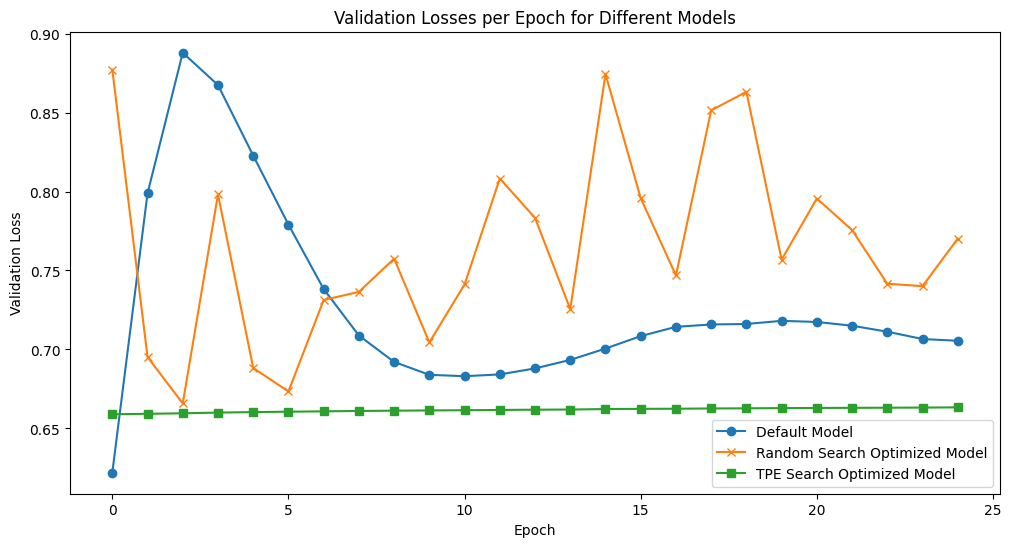

In [13]:
# Plot the validation losses for each model
plt.figure(figsize=(12, 6))

# Plot validation losses for the default model
plt.plot(default_val_losses, label='Default Model', linestyle='-', marker='o')

# Plot validation losses for the random search optimized model
plt.plot(optimized_val_losses_random, label='Random Search Optimized Model', linestyle='-', marker='x')

# Plot validation losses for the TPE search optimized model
plt.plot(optimized_val_losses_tpe, label='TPE Search Optimized Model', linestyle='-', marker='s')

# Add titles and labels
plt.title('Validation Losses per Epoch for Different Models')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()

# Show the plot
plt.show()
